In [108]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import math
from tqdm import tqdm
from matplotlib import pyplot as pl
import BstoK_ref_ff as BstoK


In [109]:
import h5py as h5

nplus=3 # number of input values for f+
nzero=3 # number of input values for f0
path=''
with h5.File(path+'zfit_data_BstoK.h5', 'r') as f:
    gp=f.get('BstoK_refdata_qsqmin_17.50_Np{:d}_Nz{:d}'.format(nplus,nzero))
    qsqinputl=np.array(gp['qsqref'])
    bskpts=np.array(gp['central'])
    bskcov=np.array(gp['stat_cov'])#np.array(gp['tot_cov'])

qsqinputl

array([23.72835562, 21.15623588, 17.5       , 23.72835562, 21.15623588,
       17.5       ])

In [110]:
dataplus = np.array([qsqinputl[0:nplus],
bskpts[0:nplus]])
dataplus=np.transpose(dataplus)

datazero = np.array([qsqinputl[nplus:],
bskpts[nplus:]])
datazero=np.transpose(datazero)

In [111]:
dataplus

array([[23.72835562,  3.16577058],
       [21.15623588,  1.82072549],
       [17.5       ,  0.98140563]])

In [112]:
covmatrix = bskcov

In [113]:
def covresample(bskpts):
    bskpts_resampled = np.random.multivariate_normal(bskpts,covmatrix)
    dataplus = np.array([qsqinputl[0:nplus],
    bskpts_resampled[0:nplus]])
    dataplus=np.transpose(dataplus)

    datazero = np.array([qsqinputl[nplus:],
    bskpts_resampled[nplus:]])
    datazero=np.transpose(datazero)
    return [dataplus,datazero]

In [114]:
chi0plus = 1.48e-02
chi1minus = 6.03e-04

In [115]:
tminus = 23.728356
tplus = 34.368484
t0 = 16.505107
tthresh = 29.349571

In [116]:
tplustrue = tplus
tplus = tthresh
tminustrue = tminus
tminus = t0 #almost all tminus's are now replaced with t0 , the equivalent is true for tplus

In [117]:
def z(t):
    return (np.sqrt(tplus-t)-np.sqrt(tplus-tminus))/(np.sqrt(tplus-t)+np.sqrt(tplus-tminus))

In [118]:
def rho(t):
    return np.sqrt((tplus-t)/(tplus-tminus))

In [119]:
ni = 1

In [120]:
def phizero(t):  #outer fn and Blanschke factors
    polevals = []
    calcz = z(t)
    calcrho = rho(t)
    phizeroval = np.sqrt(2*ni/3)*np.sqrt((3*tplustrue*tminustrue)/(4*np.pi))*1/(tplus-tminus)*(1+calcz)*np.power(1-calcz,-5/2)*np.power(rho(0)+(1+calcz)/(1-calcz),-2)*np.power(rho(0)+(1+calcz)/(1-calcz),-2)
    #for i in range(len(polevals)):
    #    phizeroval *= (z(t)-z(polevals[i]))/(1-np.conjugate(z(polevals[i]))*z(t))
    return phizeroval 

In [121]:
def phiplus(t):  #outer fn and Blanschke factors
    polevals = [5.324700**2]
    calcz = z(t)
    calcrho = rho(t)
    phiplusval = np.sqrt(2*ni/3)*np.sqrt(1/(np.pi*(tplus-tminus)))*np.power(1+calcz,2)*np.power(1-calcz,-9/2)*np.power(rho(0)+(1+calcz)/(1-calcz),-2)*np.power(rho(0)+(1+calcz)/(1-calcz),-3)
    for i in range(len(polevals)):
        phiplusval *= (z(t)-z(polevals[i]))/(1-np.conjugate(z(polevals[i]))*z(t))
    return phiplusval

In [122]:
def newphiplus(t,chi = chi1minus):
    polevals = [5.324700**2]
    #chi = 1
    eta = 1
    K = 48*np.pi
    a = 3
    b = 2
    rq = np.sqrt(tstar-t)
    rminus = np.sqrt(tstar-tminus)
    r0 = np.sqrt(tstar-t0)
    val = np.sqrt(eta/(K*chi))*(rq**((a+1)/2))*r0**(-1/2)*(rq+r0)*((rq+np.sqrt(tstar))**(-b-3))*(rq+rminus)**(a/2)
    for i in range(len(polevals)):
        val *= (z(t)-z(polevals[i]))/(1-np.conjugate(z(polevals[i]))*z(t))
    return val

In [123]:
def newphizero(t,chi = chi0plus):
    chi = 1
    eta = 1
    K = 16*np.pi/(tplus*tminus)
    a = 1
    b = 1
    rq = np.sqrt(tstar-t)
    rminus = np.sqrt(tstar-tminus)
    r0 = np.sqrt(tstar-t0)
    return np.sqrt(eta/(K*chi))*(rq**((a+1)/2))*r0**(-1/2)*(rq+r0)*((rq+np.sqrt(tstar))**(-b-3))*(rq+rminus)**(a/2)

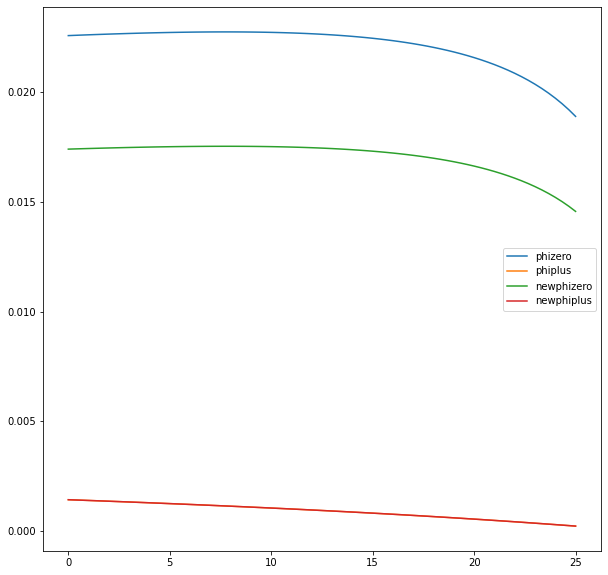

In [99]:
tspace = np.linspace(0,25,76)
plt.plot(tspace,phizero(tspace),label="phizero")
plt.plot(tspace,phiplus(tspace),label="phiplus")
plt.plot(tspace,newphizero(tspace),label="newphizero")
plt.plot(tspace,newphiplus(tspace),label="newphiplus")
plt.legend()
plt.show()

In [124]:
def exclude(G,a,b):
    return np.delete(np.delete(G,b,0),a,1)

In [125]:
def G(data,t):
    row = [t]
    row.extend(data[:,0])
    mat = np.empty([data.shape[0]+1,data.shape[0]+1])

    for i in range(len(row)):
        for j in range(len(row)):
            mat[i,j] = 1/(1-z(row[i])*z(row[j]))
    return mat

In [126]:
#### diagonalise G
def Gdiag_old(G):
    tempresult = np.linalg.eig(G)
    D = np.diag(tempresult[0])
    U = np.transpose(np.array(tempresult[1]))
    return [D,U]

In [127]:
#### diagonalise G
def Gdiag(G):
    tempresult = np.linalg.svd(G)
    D = np.diag(tempresult[1])
    U = np.transpose(np.array(tempresult[0]))
    return [D,U]

In [72]:
Gdiag(G(dataplus,10))

[array([[4.01491209e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 5.15472109e-02, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 4.53032500e-04, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.72628063e-06]]),
 array([[-0.49520421, -0.50448479, -0.50153513, -0.49872878],
        [ 0.70832863, -0.64361619, -0.22887758,  0.17788708],
        [ 0.4747028 ,  0.52033924, -0.43193883, -0.56332333],
        [-0.16643496,  0.24596824, -0.71379718,  0.63426541]])]

In [73]:
np.linalg.svd(G(datazero,5))

(array([[-0.4954725 ,  0.75901183,  0.41009375, -0.10114917],
        [-0.50379867, -0.59434652,  0.56054938,  0.2805771 ],
        [-0.50143929, -0.24801997, -0.33391361, -0.75864777],
        [-0.49925198,  0.09559993, -0.63726699,  0.57922267]]),
 array([4.00959344e+00, 7.17156572e-02, 8.58081543e-04, 3.07415905e-06]),
 array([[-0.4954725 , -0.50379867, -0.50143929, -0.49925198],
        [ 0.75901183, -0.59434652, -0.24801997,  0.09559993],
        [ 0.41009375,  0.56054938, -0.33391361, -0.63726699],
        [-0.10114917,  0.2805771 , -0.75864777,  0.57922267]]))

In [128]:
def alpha(data,t):
    ssum = 0
    temp = Gdiag(G(data,t))
    U = temp[1]
    D = temp[0]
    for i in range(0,data.shape[0]+1):
        ssum += U[i,0]*U[i,0]/D[i,i]
    return ssum

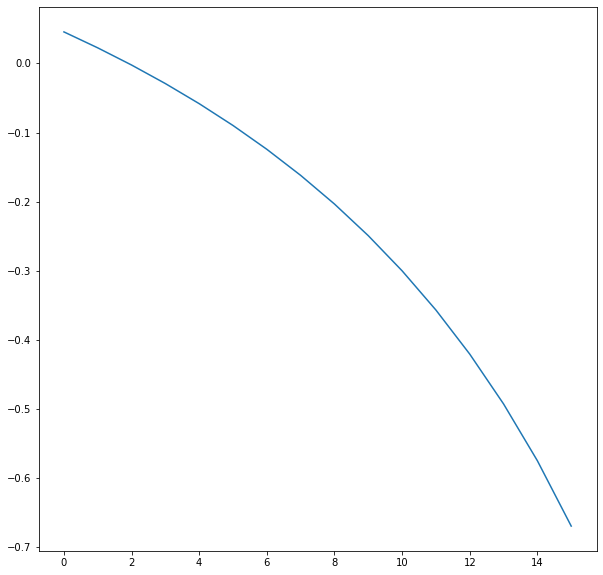

In [102]:
x = np.linspace(0,15,46,dtype=int)
plt.plot(x,[beta(dataplus,i,1)/(phiplus(i)*alpha(dataplus,i)) for i in x],label = r"alpha")



In [129]:
def beta(data, t, charge):
    if charge == 1:
        phi = phiplus
    elif charge == 0:
        phi = phizero
    ssum = 0
    temp = Gdiag(G(data,t))
    U = temp[1]
    D = temp[0]
    for i in range(0,data.shape[0]+1):
        for j in range(1,data.shape[0]+1):
            ssum += U[i,j]*data[j-1,1]*phi(data[j-1,0])*U[i,0]/D[i,i]
    return ssum

In [130]:
def (data, t, phi,chi):
    ssum = 0
    temp = Gdiag(G(data,t))
    U = temp[1]
    D = temp[0]
    for i in range(0,data.shape[0]+1):
        for j in range(1,data.shape[0]+1):
            ssum += U[i,j]*data[j-1,1]*phi(data[j-1,0],chi)*U[i,0]/D[i,i]
    return ssum

SyntaxError: invalid syntax (<ipython-input-130-6216a75f9270>, line 1)

In [131]:
def gamma(data, t,charge,chi):
    if charge == 1:
        phi = phiplus
    elif charge == 0:
        phi = phizero
    temp = Gdiag(G(data,t))
    U = temp[1]
    D = temp[0]
    ssum = chi
    for i in range(0,data.shape[0]+1):
        for j in range(1,data.shape[0]+1):
            for k in range(1,data.shape[0]+1):
                ssum -= U[i,j]*data[j-1,1]*phi(data[j-1,0])*U[i,k]*data[k-1,1]*phi(data[k-1,0])/D[i,i]
    return ssum

In [78]:
def M11(data,t,charge,chi):
    if charge == 1:
        phi = phiplus
    elif charge == 0:
        phi = phizero
    mat = np.empty([data.shape[0]+1,data.shape[0]+1])
    mat[0,0] = chi
    for i in range(1,data.shape[0]+1):
        mat[i,0] = phi(data[i-1,0])*data[i-1,1]
        mat[0,i] = phi(data[i-1,0])*data[i-1,1]
        for j in range(1,data.shape[0]+1):
            mat[i,j] = G(data,t)[i,j]
    return mat

<ipython-input-106-fba818d18bbc>:2: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(x,[np.sqrt(-alpha(dataplus,i)*gamma(dataplus,i,1,chiplus))/(phiplus(i)*alpha(dataplus,i)) for i in x],label = r"alpha")


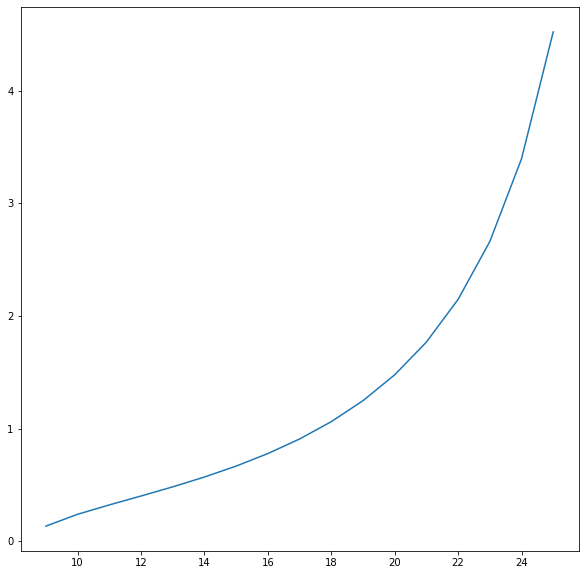

In [106]:
x = np.linspace(0,25,51,dtype=int)
plt.plot(x,[np.sqrt(-alpha(dataplus,i)*gamma(dataplus,i,1,chiplus))/(phiplus(i)*alpha(dataplus,i)) for i in x],label = r"alpha")
plt.show()


In [132]:
def formfactor(data, t,charge,chi):
    if charge == 1:
        phi = phiplus
    elif charge == 0:
        phi = phizero
    calcalpha = alpha(data,t)
    #print(data,t,charge)
    calcbeta = beta(data,t,charge)
    calcgamma = gamma(data,t,charge,chi)
    #print(calcalpha,calcbeta,calcgamma)
    temp = Gdiag(G(data,t))
    U = temp[1]
    D = temp[0]
    #print(D,U)
    discrim_old = calcbeta**2+calcalpha*calcgamma
    ssum = 0
#     for i in range(0,data.shape[0]+1):
#         for j in range(0,data.shape[0]+1):
#             if j != i:
#                 for k in range(1,data.shape[0]+1):
#                     for l in range(1,data.shape[0]+1):
#                         ssum += data[l-1,1]*phi(data[l-1,0])*data[k-1,1]*phi(data[k-1,0])*(U[i,0]*U[i,k]*U[j,0]*U[j,l]-U[i,0]*U[i,0]*U[j,k]*U[j,l])/(D[i,i]*D[j,j])
    for i in range(0,data.shape[0]):
        for j in range(i+1,data.shape[0]+1):
            for k in range(1,data.shape[0]+1):
                for l in range(1,data.shape[0]+1):
                    ssum += data[l-1,1]*phi(data[l-1,0])*data[k-1,1]*phi(data[k-1,0])*(2*U[i,0]*U[i,k]*U[j,0]*U[j,l] - U[i,0]*U[i,0]*U[j,k]*U[j,l] - U[j,0]*U[j,0]*U[i,k]*U[i,l])/(D[i,i]*D[j,j])
    discrim = ssum + calcalpha*chi
#     if discrim == discrim_old:
#         print("discrim == discrim_old")
#     else:
#         print("discrim = ",discrim," discrim_old = ",discrim_old," Difference = ",np.abs(discrim-discrim_old)*100/discrim,"%")
    #print(calcbeta**2,calcalpha*calcgamma,-calcbeta/(calcalpha*phi(t)))
    if discrim < 0:
        print("discriminant is negative: ",discrim)
        print(U,D)
        print(G(data,t))
        discrim = 0
    lowerbound = (-calcbeta-np.sqrt(discrim))/(calcalpha*phi(t))
    upperbound = (-calcbeta+np.sqrt(discrim))/(calcalpha*phi(t))
    return [lowerbound,upperbound]

In [88]:
formfactor(datazero, 0,0,chi0plus)

[-0.1332310115829502, 0.1305719008646412]

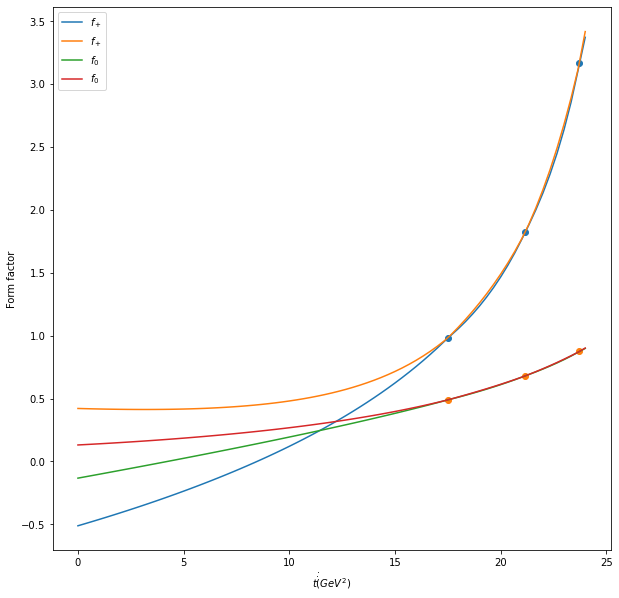

In [133]:
x = np.linspace(0,24,73)
plt.plot(x,[formfactor(dataplus,i,1,chi1minus) for i in x],label = r"$f_+$")
plt.plot(x,[formfactor(datazero,i,0,chi0plus) for i in x],label = r"$f_0$")
plt.scatter(dataplus[:,0],dataplus[:,1])
plt.scatter(datazero[:,0],datazero[:,1])

plt.xlabel(r"$t \.\.(GeV^2)$")
plt.ylabel("Form factor")
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

In [139]:
##### Uncertainty #######

In [134]:
def dispmethod(chg,tchosen,Nboot):
    fbaruplist = []
    fbarlolist = []
    accepted_resamples = []
    nancount = 0
    unifailcount = 0
    extremumnotbestcount = 0
    
    for y in range(Nboot):
        newdata = covresample(bskpts)
        newdataplus = newdata[0]
        newdatazero = newdata[1]
        
        chiplus = np.random.normal(chi1minus,0)#0.00036
        chizero = np.random.normal(chi0plus,0)#0.00133
        
        if chg == 1:
            chi = chiplus
            newdatachg = newdataplus
        if chg == 0:
            chi = chizero
            newdatachg = newdatazero
        
        plusbounds = formfactor(newdataplus,0,1,chiplus)
        zerobounds = formfactor(newdatazero,0,0,chizero)
        upper = min(plusbounds[1],zerobounds[1])
        lower = max(plusbounds[0],zerobounds[0])
        if upper <= lower:
            continue
        if np.linalg.det(M11(newdataplus,tchosen,1,chiplus)) < 0 or np.linalg.det(M11(newdatazero,tchosen,0,chizero)) < 0:
            #print("unitarity check failed")
            unifailcount += 1
            continue
        fbarup = 0
        fbarlo = np.Inf
        ########EXTREMUM CHECK############
#         ex_fbarup = 0
#         ex_fbarlo = np.Inf
        #####################################
        
        rangeN0 = np.linspace(lower,upper,N0)
        ########EXTREMUM CHECK############
#         for ex_k in [lower,upper]:
            
#             ex_originval = ex_k#np.random.uniform(lower,upper)
#             ex_extendednewdata = np.vstack([newdatachg,[0,ex_originval]])
#             ex_tchosenbounds = formfactor(ex_extendednewdata,tchosen,chg,chi)
#             ex_fbarup = max(ex_tchosenbounds[1],ex_fbarup)
#             ex_fbarlo = min(ex_tchosenbounds[0],ex_fbarlo)
        #####################################
        for k in rangeN0:
            
            originval = k#np.random.uniform(lower,upper)
            extendednewdata = np.vstack([newdatachg,[0,originval]])
            tchosenbounds = formfactor(extendednewdata,tchosen,chg,chi)
            fbarup = max(tchosenbounds[1],fbarup)
            fbarlo = min(tchosenbounds[0],fbarlo)
            
#         if [ex_fbarlo,ex_fbarup] != [fbarlo,fbarup]:
#              extremumnotbestcount += 1
        if np.isnan(fbarup):
            nancount+=1
        if nancount > 10:
            print("NaN values skipped for t=",tchosen)
            break
        fbaruplist.append(fbarup)
        fbarlolist.append(fbarlo)
        accepted_resamples.append(newdata)
    print("for t = ",tchosen," unitarity fail percentage is ",(unifailcount*100)/Nboot,"%")
    print("for t = ",tchosen," other fail percentage is ",((Nboot-len(fbarlolist)-unifailcount)*100)/Nboot,"%")
    #print("for t = ",tchosen,", NBoot = ",Nboot ,", extremumnotbestcount = ",extremumnotbestcount)
    return [fbarlolist,fbaruplist,accepted_resamples]

In [137]:
tchosenlist = np.linspace(0,20,5)
N0 = 10

In [138]:
Nboot = 50
dispresultsplus = np.empty([len(tchosenlist),4])
histplus = np.zeros([len(tchosenlist),3], dtype=np.object)
accepted_dataset_plus = np.zeros([len(tchosenlist),2], dtype=np.object)
counter = 0
for tchosen in tchosenlist:
    result = np.array(dispmethod(1,tchosen,Nboot), dtype=np.object)
    dispresultsplus[counter,0] = tchosen
    averageffplus = 0.5*(np.nanmean(result[0])+np.nanmean(result[1]))
    deltaplus = result[0:2]-np.nanmean(result[0:2])
    varpluslo = np.sum(deltaplus[0]**2)/(len(result[0])-1)
    varplusup = np.sum(deltaplus[1]**2)/(len(result[0])-1)
    rhoplus = np.dot(deltaplus[0],deltaplus[1])/(len(result[0])-1)
    varplus = ((np.nanmean(result[0])-np.nanmean(result[1]))**2)/12 + (varpluslo+varplusup+rhoplus)/3 #*np.sqrt(varpluslo)*np.sqrt(varplusup)
    dispresultsplus[counter,1] = averageffplus
    dispresultsplus[counter,2] = averageffplus-np.sqrt(varplus)
    dispresultsplus[counter,3] = averageffplus+np.sqrt(varplus)
    histplus[counter,0] = tchosen
    histplus[counter,1] = result[0]
    histplus[counter,2] = result[1]
    accepted_dataset_plus[counter,0] = tchosen
    accepted_dataset_plus[counter,1] = result[2]
    counter += 1

for t =  0.0  unitarity fail percentage is  0.0 %
for t =  0.0  other fail percentage is  0.0 %
for t =  5.0  unitarity fail percentage is  0.0 %
for t =  5.0  other fail percentage is  0.0 %
for t =  10.0  unitarity fail percentage is  0.0 %
for t =  10.0  other fail percentage is  0.0 %
for t =  15.0  unitarity fail percentage is  0.0 %
for t =  15.0  other fail percentage is  0.0 %
for t =  20.0  unitarity fail percentage is  0.0 %
for t =  20.0  other fail percentage is  0.0 %


In [139]:
dispresultszero = np.empty([len(tchosenlist),4])
histzero = np.zeros([len(tchosenlist),3], dtype=np.object)
accepted_dataset_zero = np.zeros([len(tchosenlist),2], dtype=np.object)
counter = 0
for tchosen in tchosenlist:
    result = np.array(dispmethod(0,tchosen,Nboot), dtype=np.object)
    dispresultszero[counter,0] = tchosen
    averageffzero = 0.5*(np.nanmean(result[0])+np.nanmean(result[1]))
    deltazero = result[0:2]-np.nanmean(result[0:2])
    varzerolo = np.sum(deltazero[0]**2)/(len(result[0])-1)
    varzeroup = np.sum(deltazero[1]**2)/(len(result[0])-1)
    rhozero = np.dot(deltazero[0],deltazero[1])/(len(result[0])-1)
    varzero = (np.nanmean(result[0])-np.nanmean(result[1]))**2/12 + (varzerolo+varzeroup+rhozero)/3 #*np.sqrt(varzerolo)*np.sqrt(varzeroup)
    dispresultszero[counter,1] = averageffzero
    dispresultszero[counter,2] = averageffzero-np.sqrt(varzero)
    dispresultszero[counter,3] = averageffzero+np.sqrt(varzero)                                           
    histzero[counter,0] = tchosen
    histzero[counter,1] = result[0]
    histzero[counter,2] = result[1]
    accepted_dataset_zero[counter,0] = tchosen
    accepted_dataset_zero[counter,1] = result[2]
    counter += 1

for t =  0.0  unitarity fail percentage is  0.0 %
for t =  0.0  other fail percentage is  0.0 %
for t =  5.0  unitarity fail percentage is  0.0 %
for t =  5.0  other fail percentage is  0.0 %
discriminant is negative:  -1.48076651385054e-07
[[-0.44681392 -0.4479479  -0.44742029 -0.44705352 -0.44683134]
 [ 0.33172789 -0.60634714 -0.32453    -0.04316878  0.64429535]
 [-0.29296226  0.54634699 -0.2228452  -0.54743009  0.51607983]
 [ 0.66920556  0.33125336 -0.56996904 -0.10364209 -0.32684666]
 [ 0.39579157 -0.15317316  0.5656595  -0.69846848 -0.10980951]] [[5.00244901e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 1.06289900e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.44918535e-03 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.64739848e-05
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.03755039e-07]]
[[1.01053058 0.97962924 0.98870328 0.99794

In [130]:
accepted_dataset_var = np.zeros([3,5])
accepted_dataset_plus_stacked = np.zeros([3,1])
#print(accepted_dataset_stacked)
for i in range(accepted_dataset_plus.shape[0]):
    for j in range(len(accepted_dataset_plus[i][1])):
        temp_accepted_column = np.zeros([3,1])
        for n in range(3):
            temp_accepted_column[n,0] = accepted_dataset_plus[i][1][j][n][1]
        #print(temp_accepted_column)
        accepted_dataset_plus_stacked  = np.hstack((accepted_dataset_plus_stacked,temp_accepted_column))
accepted_dataset_plus_stacked = accepted_dataset_plus_stacked[:,1:]

ValueError: setting an array element with a sequence.

In [ ]:
accepted_dataset_zero_stacked = np.zeros([3,1])
#print(accepted_dataset_stacked)
for i in range(accepted_dataset_zero.shape[0]):
    for j in range(len(accepted_dataset_zero[i][1])):
        temp_accepted_column = np.zeros([3,1])
        for n in range(3):
            temp_accepted_column[n,0] = accepted_dataset_zero[i][1][j][n][2]
        #print(temp_accepted_column)
        accepted_dataset_zero_stacked  = np.hstack((accepted_dataset_zero_stacked,temp_accepted_column))
accepted_dataset_zero_stacked = accepted_dataset_zero_stacked[:,1:]


In [ ]:
plt.hist(accepted_dataset_plus_stacked[0,:],bins=25,color="blue", alpha=0.5)
plt.hist(accepted_dataset_plus_stacked[1,:],bins=25,color="green", alpha=0.5)
plt.hist(accepted_dataset_plus_stacked[2,:],bins=25,color="red", alpha=0.5)
plt.show()

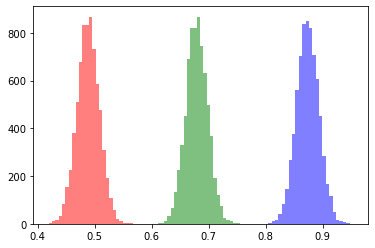

In [42]:
plt.hist(accepted_dataset_zero_stacked[0,:],bins=25,color="blue", alpha=0.5)
plt.hist(accepted_dataset_zero_stacked[1,:],bins=25,color="green", alpha=0.5)
plt.hist(accepted_dataset_zero_stacked[2,:],bins=25,color="red", alpha=0.5)
plt.show()

In [43]:
accepted_dataset_var[:,0] = data[:,0]
#for i in range(3):
accepted_dataset_var[:,1] = np.mean(accepted_dataset_plus_stacked,axis=1)
accepted_dataset_var[:,2] = np.std(accepted_dataset_plus_stacked,axis=1)
accepted_dataset_var[:,3] = np.mean(accepted_dataset_zero_stacked,axis=1)
accepted_dataset_var[:,4] = np.std(accepted_dataset_zero_stacked,axis=1)
for i in range(accepted_dataset_var.shape[0]):
    for j in range(accepted_dataset_var.shape[1]):
        accepted_dataset_var[i,j] = round(accepted_dataset_var[i,j],4)
accepted_dataset_var

array([[2.37284e+01, 3.16570e+00, 3.83000e-02, 8.73800e-01, 1.96000e-02],
       [2.11562e+01, 1.82080e+00, 4.48000e-02, 6.79300e-01, 1.90000e-02],
       [1.75000e+01, 9.81600e-01, 5.42000e-02, 4.88800e-01, 1.95000e-02]])

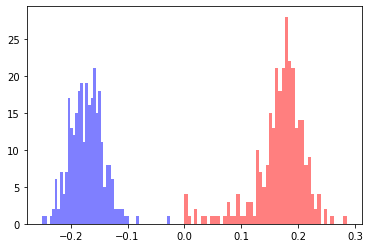

In [44]:
plt.hist(histzero[0,1],bins=50,color="blue", alpha=0.5)
plt.hist(histzero[0,2],bins=50,color="red", alpha=0.5)
plt.show()

In [45]:
len(histplus[0,2])

288

In [140]:
errortable = np.zeros([len(tchosenlist),5])
counter = 0
for t in tchosenlist:
    errortable[counter,0] = t
    errortable[counter,3] = round(dispresultszero[counter,1],3)
    errortable[counter,4] = round(dispresultszero[counter,1] - dispresultszero[counter,2],3)
    errortable[counter,1] = round(dispresultsplus[counter,1],3)
    errortable[counter,2] = round(dispresultsplus[counter,1] - dispresultsplus[counter,2],3)
    counter += 1

errortable

array([[ 0.000e+00, -4.000e-03,  1.200e-01,  1.400e-02,  1.300e-01],
       [ 5.000e+00,  1.130e-01,  1.040e-01,  1.090e-01,  8.100e-02],
       [ 1.000e+01,  3.160e-01,  6.800e-02,  2.340e-01,  5.200e-02],
       [ 1.500e+01,  6.750e-01,  4.000e-02,  3.870e-01,  1.900e-02],
       [ 2.000e+01,  1.478e+00,  3.400e-02,  6.130e-01,  1.000e-02]])

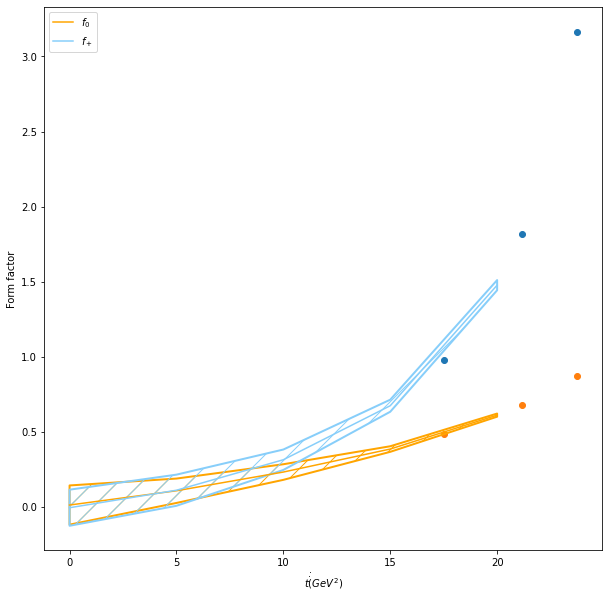

In [141]:
#x = np.linspace(0,2,101)
plt.scatter(dataplus[:,0],dataplus[:,1])
plt.scatter(datazero[:,0],datazero[:,1])
plt.plot(dispresultszero[:,0],dispresultszero[:,1],label = r"$f_0$",color="orange")
pl.fill_between(dispresultszero[:,0],dispresultszero[:,2],dispresultszero[:,3],linewidth=2,hatch='/',edgecolor="orange",facecolor="none")
plt.plot(dispresultsplus[:,0],dispresultsplus[:,1],label = r"$f_+$",color="lightskyblue")
pl.fill_between(dispresultsplus[:,0],dispresultsplus[:,2],dispresultsplus[:,3],linewidth=2,hatch='/',edgecolor="lightskyblue",facecolor="none")

plt.xlabel(r"$t \.\. (GeV^2)$")
plt.ylabel("Form factor")
plt.legend()
plt.rcParams["figure.figsize"] = (25,15)
plt.show()

In [307]:
def zerohistogramdata(chg,Nboot):
    upperlist = []
    lowerlist = []
    unifailcount = 0
    for y in tqdm(range(Nboot)):
        newdata = covresample(bskpts)
        newdataplus = newdata[0]
        newdatazero = newdata[1]
        
        chiplus = np.random.normal(chi1minus,0)#0.00036
        chizero = np.random.normal(chi0plus,0)#0.00133
        
        if chg == 1:
            chi = chiplus
            newdatachg = newdataplus
        if chg == 0:
            chi = chizero
            newdatachg = newdatazero
        
        bounds = formfactor(newdatazero,0,chg,chi)
        upper = bounds[1]
        lower = bounds[0]
        if upper <= lower:
            continue
        if np.linalg.det(M11(newdatachg,tchosen,1,chiplus)) < 0 or np.linalg.det(M11(newdatazero,tchosen,0,chizero)) < 0:
            #print("unitarity check failed")
            unifailcount += 1
            continue
        
        upperlist.append(upper)
        lowerlist.append(lower)
    print("for t = 0 unitarity fail percentage is ",(unifailcount*100)/Nboot,"%")
    print("for t = 0 other fail percentage is ",((Nboot-len(lowerlist)-unifailcount)*100)/Nboot,"%")
    return [lowerlist,upperlist]

In [308]:
histresults = zerohistogramdata(1,5000)

100%|██████████| 5000/5000 [00:38<00:00, 129.49it/s]

for t = 0 unitarity fail percentage is  0.0 %
for t = 0 other fail percentage is  0.0 %


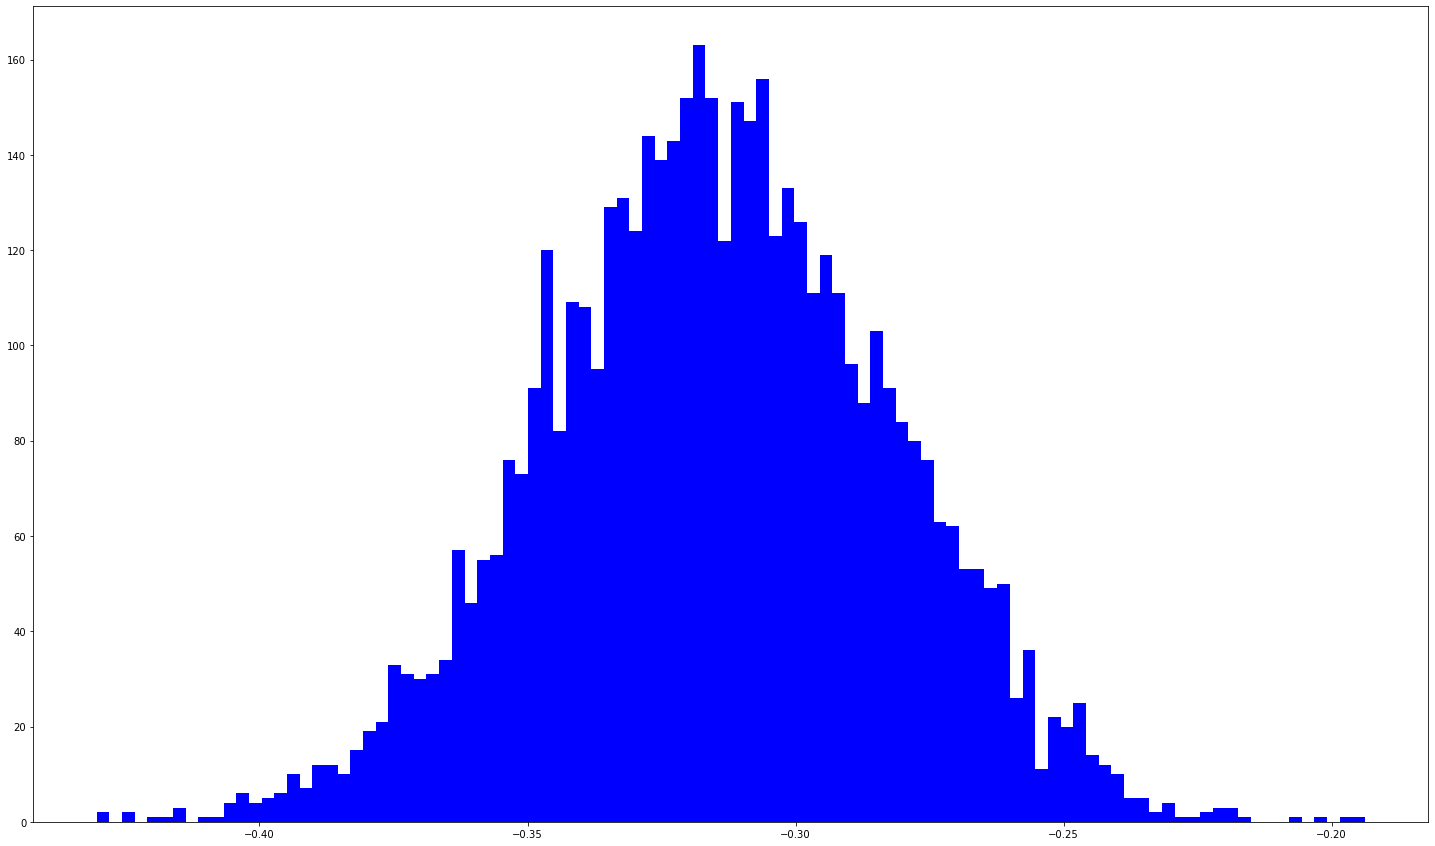

In [311]:
plt.hist(histresults[0],bins=100,color="blue", alpha=1)
plt.show()

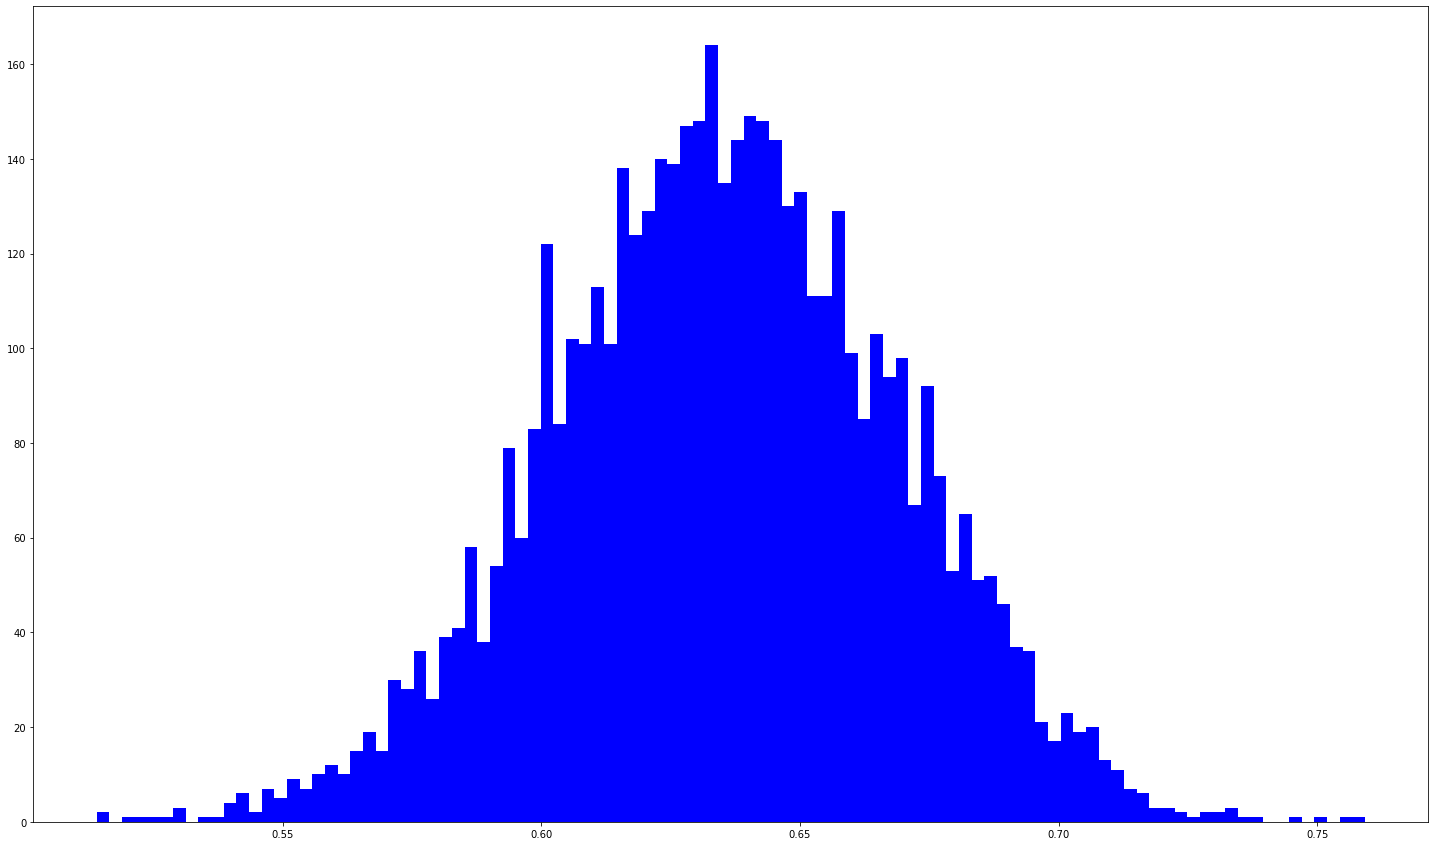

In [310]:
plt.hist(histresults[1],bins=100,color="blue", alpha=1)
plt.show()

In [234]:
histresultstable = np.zeros([1,4])
histresultstable[0,0] = np.mean(histresults[0])
histresultstable[0,1] = np.std(histresults[0])
histresultstable[0,2] = np.mean(histresults[1])
histresultstable[0,3] = np.std(histresults[1])
for i in range(histresultstable.shape[0]):
    for j in range(histresultstable.shape[1]):
        histresultstable[i,j] = round(histresultstable[i,j],4)
histresultstable

array([[0.7521, 0.0304, 0.7794, 0.0304]])

In [194]:
def dispmethod_overlap(chg,tchosen,Nboot,N0,N0index):
    fbaruplist = []
    fbarlolist = []
    accepted_resamples = []
    nancount = 0
    unifailcount = 0
    extremumnotbestcount = 0
    if chg == 1:
            phi = phiplus
    if chg == 0:
            phi = phizero
    #print(phi(tchosen))
    printval = 0
    for y in range(Nboot):
        newdata = covresample(bskpts)
        newdataplus = newdata[0]
        newdatazero = newdata[1]
        
        chiplus = np.random.normal(chi1minus,0)#0.00036
        chizero = np.random.normal(chi0plus,0)#0.00133 
        if chg == 1:
            chi = chiplus
            newdatachg = newdataplus
            phi = phiplus
        if chg == 0:
            chi = chizero
            newdatachg = newdatazero
            phi = phizero
        
        plusbounds = formfactor(newdataplus,0,1,chiplus)
        zerobounds = formfactor(newdatazero,0,0,chizero)
        upper = min(plusbounds[1],zerobounds[1])
        lower = max(plusbounds[0],zerobounds[0])
        if upper <= lower:
            continue
        if np.linalg.det(M11(newdataplus,tchosen,1,chiplus)) < 0 or np.linalg.det(M11(newdatazero,tchosen,0,chizero)) < 0:
            #print("unitarity check failed")
            unifailcount += 1
            continue
        fbarup = 0
        fbarlo = np.Inf
        ########EXTREMUM CHECK############
#         ex_fbarup = 0
#         ex_fbarlo = np.Inf
        #####################################
        
        rangeN0 = np.linspace(lower,upper,N0)
        ########EXTREMUM CHECK############
#         for ex_k in [lower,upper]:
            
#             ex_originval = ex_k#np.random.uniform(lower,upper)
#             ex_extendednewdata = np.vstack([newdatachg,[0,ex_originval]])
#             ex_tchosenbounds = formfactor(ex_extendednewdata,tchosen,chg,chi)
#             ex_fbarup = max(ex_tchosenbounds[1],ex_fbarup)
#             ex_fbarlo = min(ex_tchosenbounds[0],ex_fbarlo)
        #####################################
        kval = lower + (upper-lower)*N0index/N0
        
        originval = kval#np.random.uniform(lower,upper)
        extendednewdata = np.vstack([newdatachg,[0,originval]])
        tchosenbounds = formfactor(extendednewdata,tchosen,chg,chi)
        
        #print(np.linalg.eig(M11(extendednewdata,tchosen,chg,chi))[0])
        #print(np.linalg.det(M11(extendednewdata,tchosen,chg,chi)))
        print(beta(extendednewdata,tchosen,chg))
#         comparisonvar = alpha(extendednewdata)*phi(tchosen)
#         if printval != comparisonvar:
#             print(comparisonvar)
#         printval = comparisonvar
        fbarup = max(tchosenbounds[1],fbarup)
        fbarlo = min(tchosenbounds[0],fbarlo)
        #print([fbarlo,fbarup])
#         if [ex_fbarlo,ex_fbarup] != [fbarlo,fbarup]:
#              extremumnotbestcount += 1
        if np.isnan(fbarup):
            nancount+=1
        if nancount > 10:
            print("NaN values skipped for t=",tchosen)
            break
        fbaruplist.append(fbarup)
        fbarlolist.append(fbarlo)
        accepted_resamples.append(newdata)
    #print("for t = ",tchosen," unitarity fail percentage is ",(unifailcount*100)/Nboot,"%")
    #print("for t = ",tchosen," other fail percentage is ",((Nboot-len(fbarlolist)-unifailcount)*100)/Nboot,"%")
    #print("for t = ",tchosen,", NBoot = ",Nboot ,", extremumnotbestcount = ",extremumnotbestcount)
    return [fbarlolist,fbaruplist,accepted_resamples]

In [234]:
###Investigating why extrema are not optimal at t=23 ###
tchoices = np.linspace(16,25,10)#[23]
N0 = 10
exresults = np.zeros([len(tchoices),3,N0+1])
tindex = 0
charge = 1
for tchoice in tqdm(tchoices):
    counter = 0
    for N0index in np.linspace(0,N0,N0+1):
        tempresults = dispmethod_overlap(charge,tchoice,1,N0,N0index)
        exresults[tindex,0,counter] = N0index
        exresults[tindex,1,counter] = np.mean(tempresults[0])
        exresults[tindex,2,counter] = np.mean(tempresults[1])
        counter += 1
    tindex += 1

  0%|          | 0/10 [00:00<?, ?it/s]

-23164.576639861505
-26839.741674655
-26335.76898517821
-24909.761407771937
-27849.420522837274
-27961.603067270167
-25280.463566772534
-24834.087341255723


 10%|█         | 1/10 [00:00<00:02,  3.48it/s]

-24849.763996569418
-24732.630151605244
-27222.188303170544
-362812.26878956694
-329005.5829218276
-330367.12251929025
-332665.4753378172
-331343.1992118642


 20%|██        | 2/10 [00:00<00:02,  3.50it/s]

-330450.66727687634
-355749.2299173369
-337288.6005210263
-324954.1128131469
-324688.0772376107
-319550.8888775253
-544162.9364830384
-554823.9455253375
-544829.0869539083


 30%|███       | 3/10 [00:00<00:01,  3.50it/s]

-561097.9748716563
-515042.3636057779
-546593.1029612565
-549105.1206328083
-548129.9147386457
-529330.1842310186
-543216.9875318924
-526596.6597491838
-123658.98773331667
-130172.88642603654
-124438.96523232605


 40%|████      | 4/10 [00:01<00:01,  3.49it/s]

-125288.17850036849
-126697.7187025435
-128114.60710739752
-128091.7724238208
-127846.22260039806
-127739.97874634003
-120906.54103717042
-126603.57634503838
-161210.0137802525
-169309.0398126493


 50%|█████     | 5/10 [00:01<00:01,  3.47it/s]

-163533.78680197592
-164130.12698866084
-166448.12528513983
-162116.18872136125
-161488.78522226025
-168585.24005507352
-160712.55617785038
-159420.11028751047
-165528.13050692217
-5410677.8513640845
-5315328.98665591
-5465121.922357406
-5364241.0844967235
-5270222.753278071
-5356051.851086893
-5393245.450931333
-5451075.414661152


 60%|██████    | 6/10 [00:01<00:01,  3.41it/s]

-5445219.052651927
-5356531.973887549
-5311123.963823356
-164503.79862200632
-167736.32376285357
-166159.42743502103
-168735.94831093156
-160309.35479349236
-165062.83816064365
-168807.11484592422


 70%|███████   | 7/10 [00:02<00:00,  3.37it/s]

-160282.29802653234
-162232.10286606586
-169564.0456097337
-164722.4492498176
-74815.18131546065
-72055.21800701984
-72917.54427288474
-72797.23873619788
-74975.10677750931
-74867.37920905984
-71338.76459719555


 80%|████████  | 8/10 [00:02<00:00,  3.41it/s]

-71588.12078988785
-75628.56953539647
-75690.69078783003
-76456.04499023569
-84723.78525528172
-81689.26384842774
-80963.27967839711
-86462.16837072691
-80481.01948802716
-86506.99843925715
-84213.22221163129


 90%|█████████ | 9/10 [00:02<00:00,  3.46it/s]

-85768.13307421969
-87579.32236391332
-82181.26342146908
-85066.04572822174
-761.9366436941835
-751.5252375242706
-734.6607391116803
-747.9750108463993
-754.1084202296369
-729.4802117217009


100%|██████████| 10/10 [00:02<00:00,  3.43it/s]

-740.3132774559714
-722.8100694196952
-709.5512234697569
-740.1196837802689
-737.3401194310095


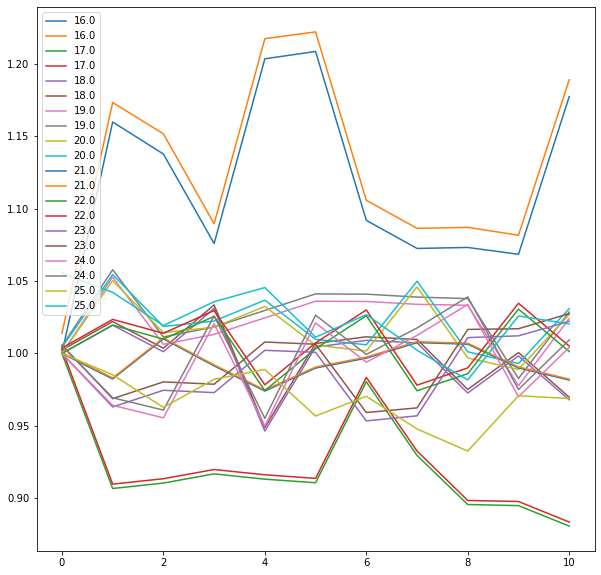

In [235]:
for i in range(0,len(tchoices)):
    plt.plot(exresults[i,0,:],exresults[i,1,:]/exresults[i,1,0],label=tchoices[i])
    plt.plot(exresults[i,0,:],exresults[i,2,:]/exresults[i,1,0],label=tchoices[i])
plt.legend()

plt.rcParams["figure.figsize"] = (25,15)
plt.show()